In [1]:
import sys
sys.path.append('../../../')

In [2]:
import datetime
#import pendulum
import pandas as pd
import matplotlib.pyplot as plt

from epftoolbox.evaluation import MAE, sMAPE, MAPE, rMAE
from epftoolbox.data import read_data_refreshed, read_local_data
import pandas as pd
import numpy as np
import datetime as dt
import os
pd.options.display.max_rows=None
pd.options.display.max_columns=None

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
df_test =  pd.read_csv('')
df_test.Date_Chicago = pd.to_datetime(df_test.Date_Chicago).dt.tz_localize('America/Chicago', ambiguous='infer', nonexistent='shift_forward')
df_test.loc[df_test.Date_Chicago == '10/24/2019 13:00:00']

,Date_Chicago,price_prediction_J1
4621,2019-10-24 13:00:00-05:00,43.151


2021-01-03 00:00:00
./examples/datasets
./examples/experimental_files
467
(467, 24)


/var/folders/h9/3f0fc1qs2t3943x127_ynxmc0000gn/T/ipykernel_6275/2887198728.py:40: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ff = ff.loc[begin_test_date:end_test_date]


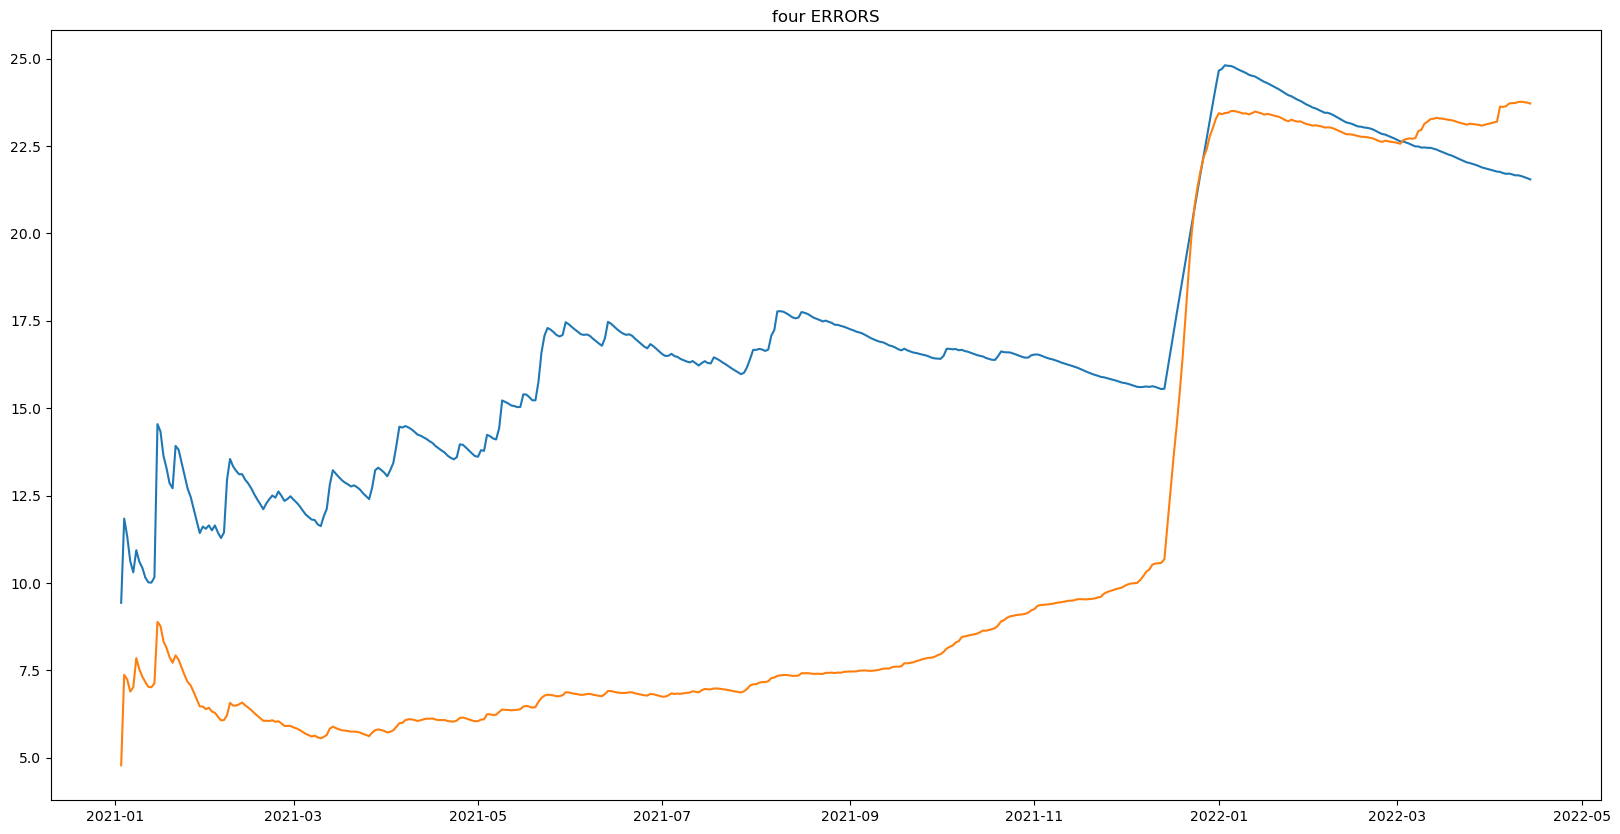

In [4]:
forecast_fournisseur= pd.read_csv('/Users/dorianfitton/Library/Mobile Documents/com~apple~CloudDocs/Documents/Cours_Télécom/fil_rouge/fil_rouge.nosync/examples/datasets/FR_fournisseur.csv')
forecast_fournisseur.Date_Chicago = pd.to_datetime(forecast_fournisseur.Date_Chicago).dt.tz_localize('America/Chicago', ambiguous='infer', nonexistent='shift_forward')
forecast_fournisseur.Date_Chicago = forecast_fournisseur.Date_Chicago.apply(lambda x: x.tz_convert('UTC'))
#forecast_fournisseur.Date_Chicago = forecast_fournisseur.Date_Chicago.apply(lambda x: x.tz_convert(None))
forecast_fournisseur= forecast_fournisseur.set_index('Date_Chicago', inplace=False)

forecast_fournisseur = forecast_fournisseur[~forecast_fournisseur.index.duplicated(keep='first')]
forecast_fournisseur['Date'] = forecast_fournisseur.index.date
forecast_fournisseur['Hour'] = forecast_fournisseur.index.hour
def turn_hourly_to_24_columns_per_day(df):
    df['Date'] = df.index.date
    df['Hour'] = df.index.hour
    df = df.pivot_table(index='Date', columns='Hour', values='price_prediction_J1')
    return df

index = pd.date_range(start=forecast_fournisseur.index[0], end=forecast_fournisseur.index[-1], freq='H')
data = np.zeros(len(index))
d = {'Price': data}
ff = pd.DataFrame(data=d,index=index)
i=0
for h in forecast_fournisseur.index:
    ff.loc[h] = forecast_fournisseur.loc[h].price_prediction_J1
    i=+1



forecast_lear = pd.read_csv('/Users/dorianfitton/Library/Mobile Documents/com~apple~CloudDocs/Documents/Cours_Télécom/fil_rouge/fil_rouge.nosync/examples/experimental_files/fc_nl_datFR_BEGIN_None_YT2_CW1456.csv', index_col=0)
forecast_lear.index = pd.to_datetime(forecast_lear.index)

begin_test_date = forecast_lear.index[0]
print(begin_test_date)
#end_test_date = forecast_lear.index[-1]
#print(end_test_date)
end_test_date = '2022-04-14 23:00:00'
path_datasets_folder = os.path.join('.', 'examples/datasets')
print(path_datasets_folder)
path_recalibration_folder = os.path.join('.', 'examples/experimental_files')
print(path_recalibration_folder)

ff = ff.loc[begin_test_date:end_test_date]
index_ff = pd.date_range(begin_test_date, end_test_date, freq='D')
ff = ff.Price.values.reshape(-1, 24)
print(len(index_ff))
print(ff.shape)

dataset = 'FR'
years_test = 2
calibration_window = 4

df_train, df_test = read_local_data(dataset='FR', path = path_datasets_folder , years_test=None,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)


# Defining unique name to save the forecast_fournisseur
forecast_fournisseur_file_name = 'fc_nl' + '_dat' + str(dataset) +'_BEGIN_' + str(begin_test_date) +'_YT' + str(years_test) + \
                     '_CW' + str(calibration_window) + '.csv'

forecast_fournisseur_file_path = os.path.join(path_recalibration_folder, forecast_fournisseur_file_name)


# Defining empty forecast_fournisseur array and the real values to be predicted in a more friendly format
#forecast_fournisseur = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=index_ff, columns=forecast_lear.columns)
forecast_fournisseur = pd.DataFrame(ff, index=index_ff, columns=forecast_lear.columns)


forecast_fournisseur = forecast_fournisseur.fillna(value=0)

MAE_four = np.zeros(len(forecast_fournisseur.index))
SMAPE_four = np.zeros(len(forecast_fournisseur.index))
i=0
for date in forecast_fournisseur.index:
    mae = np.mean(MAE(forecast_fournisseur.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast_fournisseur.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    SMAPE_four[i]=smape
    MAE_four[i]=mae
    i+=1

real_values.index = pd.to_datetime(real_values.index).tz_localize(None)

print('sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(np.mean(SMAPE_four), np.mean(MAE_four)))


d_four = {'sMAPE_four': SMAPE_four, 'MAE_four': MAE_four}
df_er_four = pd.DataFrame(data=d_four, index= forecast_fournisseur.index)
plt.figure(figsize=(20, 10))
plt.plot(df_er_four)
plt.title('four ERRORS')
plt.show()
